# IQI‑BGWO‑SVM on MIAS (Breast Cancer Classification)
This Colab notebook implements:
- MIAS data loading (PGM images)
- ROI extraction using MIAS (x,y,r)
- Feature extraction (GLCM, LBP, intensity stats, simple shape)
- Baselines + SVM (RBF)
- IQI‑BGWO optimization for feature selection + SVM hyperparameters
- 10‑fold CV evaluation (Accuracy, Sensitivity, Specificity, AUC, MCC)

## What you must set
Update `DRIVE_ZIP_PATH` to the zip you uploaded in Google Drive.


In [ ]:
#@title 1) Setup
# Install scikit-image and other packages; pip will handle numpy dependency
import sys
import subprocess

def _maybe_install_deps():
    pkgs = [
        "scikit-image",
        "scikit-learn",
        "matplotlib",
        "PyPDF2",
        "tqdm",
    ]
    try:
        import skimage  # noqa: F401
        import sklearn  # noqa: F401
        import matplotlib  # noqa: F401
        import PyPDF2  # noqa: F401
        import tqdm  # noqa: F401
        return
    except Exception:
        pass
    print("Installing required packages:", " ".join(pkgs))
    subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs])

_maybe_install_deps()

import os, re, math, random, json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False
    print("google.colab not available; skipping Drive mount. Set DRIVE_ZIP_PATH to a local file path.")


Installing required packages: scikit-image scikit-learn matplotlib PyPDF2 tqdm
Mounted at /content/drive


In [ ]:
#@title 2) Unzip MIAS dataset from Google Drive
import zipfile, pathlib, shutil

# ? TODO: set this to YOUR zip file path
if IN_COLAB:
    DRIVE_ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/ML project /miasdbv1.21.zip"  # <-- change me
    DATA_DIR = pathlib.Path("/content/mias_data")
else:
    DRIVE_ZIP_PATH = str(pathlib.Path.cwd() / "miasdbv1.21.zip")  # <-- change me
    DATA_DIR = pathlib.Path.cwd() / "mias_data"

# Where we will extract
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Clean previous extraction (optional)
if (DATA_DIR / "images").exists():
    shutil.rmtree(DATA_DIR / "images")
(DATA_DIR / "images").mkdir(parents=True, exist_ok=True)

assert os.path.exists(DRIVE_ZIP_PATH), f"Zip not found: {DRIVE_ZIP_PATH}"

with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as z:
    z.extractall(DATA_DIR)

print("Extracted to:", DATA_DIR)
print("Top-level files:", sorted([p.name for p in DATA_DIR.iterdir()])[:25])

# Try to discover image files
pgm_files = list(DATA_DIR.rglob("mdb*.pgm"))
print("Found PGM images:", len(pgm_files))
if len(pgm_files) == 0:
    raise RuntimeError("No mdb*.pgm files found in the extracted zip. Ensure the zip contains MIAS PGM images.")


Extracted to: /content/mias_data
Top-level files: ['MIASDBv1.21', 'images']
Found PGM images: 322


In [ ]:
import os

if IN_COLAB:
    # List contents of your Google Drive's MyDrive folder
    drive_path = '/content/drive/MyDrive'
    print(f"Contents of {drive_path}:")

    found_zip = False
    for root, dirs, files in os.walk(drive_path):
        for file in files:
            if 'mias' in file.lower() and file.endswith('.zip'):
                full_path = os.path.join(root, file)
                print(f"Found potential MIAS zip file: {full_path}")
                found_zip = True
                # Print full path and break if we find a likely candidate
                print(f'Please use this path for DRIVE_ZIP_PATH: "{full_path}"')
                break
        if found_zip:
            break

    if not found_zip:
        print("No MIAS zip file found. Please ensure it's uploaded to your Google Drive.")

Contents of /content/drive/MyDrive:
Found potential MIAS zip file: /content/drive/MyDrive/Colab Notebooks/ML project /miasdbv1.21.zip
Please use this path for DRIVE_ZIP_PATH: "/content/drive/MyDrive/Colab Notebooks/ML project /miasdbv1.21.zip"


In [ ]:
#@title 3) Find/parse MIAS truth-data (README table)
from PyPDF2 import PdfReader

def parse_mias_table_from_text(lines):
    """Parse MIAS table rows like:
    mdb001lm G CIRC B 1815 1116 790
    Also supports rows without ROI coords (e.g., NORM).
    Returns a DataFrame with one row per abnormality entry.
    """
    rows = []
    current_id = None
    for raw in lines:
        line = raw.strip()
        if not line:
            continue
        # Collapse multiple spaces
        line = re.sub(r"\s+", " ", line)
        # Row may start with mdb...
        if line.startswith("mdb") and len(line) >= 7:
            parts = line.split(" ")
            # Minimum: id tissue class
            if len(parts) >= 3:
                img_id = parts[0]
                tissue = parts[1]
                abn = parts[2]
                sev = None
                x = y = r = None
                if len(parts) >= 4:
                    sev = parts[3] if parts[3] in ("B","M") else None
                # coords
                if len(parts) >= 7:
                    try:
                        x, y, r = int(parts[4]), int(parts[5]), int(parts[6])
                    except:
                        x = y = r = None
                rows.append(dict(image_id=img_id, tissue=tissue, abnormality=abn, severity=sev, x=x, y=y, r=r))
                current_id = img_id
        else:
            # Some images have multiple abnormalities; continuation line begins with abnormality name
            # Example:
            #  CIRC B 786 1255 107
            parts = line.split(" ")
            if current_id and len(parts) >= 2 and parts[0] in ("CALC","CIRC","SPIC","MISC","ARCH","ASYM","NORM"):
                abn = parts[0]
                sev = parts[1] if parts[1] in ("B","M") else None
                x = y = r = None
                if len(parts) >= 5:
                    try:
                        x, y, r = int(parts[2]), int(parts[3]), int(parts[4])
                    except:
                        x=y=r=None
                rows.append(dict(image_id=current_id, tissue=None, abnormality=abn, severity=sev, x=x, y=y, r=r))
    df = pd.DataFrame(rows)
    return df

def load_truth_data(DATA_DIR):
    # Search for a text truth-data file
    txt_candidates = list(DATA_DIR.rglob("*.txt")) + list(DATA_DIR.rglob("*.dat"))
    pdf_candidates = list(DATA_DIR.rglob("00README.pdf")) + list(DATA_DIR.rglob("README.pdf")) + list(DATA_DIR.rglob("*README*.pdf"))

    if txt_candidates:
        # Try parse from any txt containing 'mdb'
        for p in txt_candidates:
            text = p.read_text(errors="ignore")
            if "mdb001" in text or "mdb" in text:
                df = parse_mias_table_from_text(text.splitlines())
                if len(df) > 0:
                    print("Parsed truth-data from text file:", p)
                    return df, p
    if pdf_candidates:
        p = pdf_candidates[0]
        reader = PdfReader(str(p))
        lines = []
        for page in reader.pages:
            t = page.extract_text() or ""
            lines.extend(t.splitlines())
        df = parse_mias_table_from_text(lines)
        if len(df) > 0:
            print("Parsed truth-data from PDF:", p)
            return df, p

    raise RuntimeError("Could not find/parse MIAS truth-data (README table). Put 00README.pdf or a text table inside the zip.")

truth_df, truth_source = load_truth_data(DATA_DIR)
truth_df.head(), truth_df.shape


Parsed truth-data from PDF: /content/mias_data/MIASDBv1.21/00README.pdf


(   image_id tissue abnormality severity       x       y      r
 0  mdb001lm      G        CIRC        B  1815.0  1116.0  790.0
 1  mdb002rl      G        CIRC        B  3091.0  1262.0  277.0
 2   mdb003l      l           D     None     NaN     NaN    NaN
 3  mdb004rl      D        NORM     None     NaN     NaN    NaN
 4  mdb005ll      F        CIRC        B   647.0  1163.0  122.0,
 (330, 7))

In [ ]:
#@title 4) Prepare binary labels (Benign vs Malignant) and ROI rows
# Keep only abnormal cases with severity B/M and with ROI coords present
abn = truth_df.copy()

# Some rows have tissue=None for continuation lines. We'll forward-fill tissue per image_id when possible.
abn['tissue'] = abn.groupby('image_id')['tissue'].ffill()

# binary classification: B vs M
abn = abn[abn['severity'].isin(['B','M'])].copy()

# Need ROI coords
abn = abn.dropna(subset=['x','y','r']).copy()

abn['label'] = (abn['severity'] == 'M').astype(int)  # Malignant=1
print("Abnormal ROI entries:", len(abn))
print(abn['label'].value_counts())

abn.head()


Abnormal ROI entries: 117
label
0    66
1    51
Name: count, dtype: int64


,image_id,tissue,abnormality,severity,x,y,r,label
0,mdb001lm,G,CIRC,B,1815.0,1116.0,790.0,0
1,mdb002rl,G,CIRC,B,3091.0,1262.0,277.0,0
4,mdb005ll,F,CIRC,B,647.0,1163.0,122.0,0
5,mdb005ll,F,CIRC,B,786.0,1255.0,107.0,0
10,mdb010rm,F,CIRC,B,2509.0,975.0,135.0,0


from matplotlib import pyplot as plt
_df_21['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['x'].plot(kind='hist', bins=20, title='x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24['r'].plot(kind='hist', bins=20, title='r')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_25.groupby('image_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_26.groupby('tissue').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_27.plot(kind='scatter', x='index', y='x', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_28.plot(kind='scatter', x='x', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_29.plot(kind='scatter', x='y', y='r', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['x']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_30.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('image_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='image_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('x')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['x']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_31.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('tissue')):
  _plot_series(series, series_name, i)
  fig.legend(title='tissue', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('x')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_32.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('image_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='image_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_33.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('tissue')):
  _plot_series(series, series_name, i)
  fig.legend(title='tissue', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
_df_34['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_35['x'].plot(kind='line', figsize=(8, 4), title='x')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_36['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_37['r'].plot(kind='line', figsize=(8, 4), title='r')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['tissue'].value_counts()
    for x_label, grp in _df_38.groupby('image_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('image_id')
_ = plt.ylabel('tissue')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_39['image_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_39, x='index', y='image_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_40['tissue'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_40, x='index', y='tissue', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_41['image_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_41, x='x', y='image_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_42['tissue'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_42, x='x', y='tissue', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

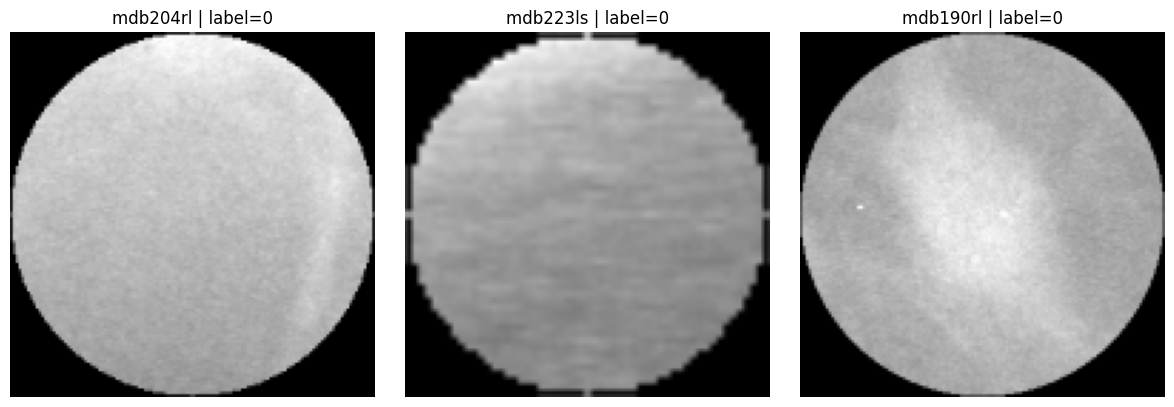

In [ ]:
#@title 5) PGM loader + ROI extraction (fixed)
from pathlib import Path
import numpy as np
from skimage import io as skio
from skimage.transform import resize
import matplotlib.pyplot as plt

def find_image_path(image_id, base_dir):
    """
    Finds the PGM file corresponding to a MIAS image_id (e.g., mdb001lm).
    Searches recursively under base_dir.
    """
    base_dir = Path(base_dir)

    # Exact match first
    candidates = list(base_dir.rglob(f"{image_id}.pgm"))
    if candidates:
        return candidates[0]

    # Fallback: any file starting with image_id
    candidates = list(base_dir.rglob(f"{image_id}*.pgm"))
    if candidates:
        return candidates[0]

    # Case-insensitive fallback (rare)
    image_id_low = image_id.lower()
    for p in base_dir.rglob("*.pgm"):
        if p.stem.lower().startswith(image_id_low):
            return p

    return None

def to_grayscale(img):
    """Convert image to 2D grayscale if it loads as multi-channel."""
    if img.ndim == 2:
        return img
    if img.ndim == 3:
        # average channels (safe and simple)
        return img[..., :3].mean(axis=2)
    raise ValueError(f"Unexpected image shape: {img.shape}")

def extract_circular_roi(img, x, y, r, out_size=128):
    """
    Extract a circular ROI centered at (x,y) with radius r.
    MIAS uses x,y in image coordinates (col=x, row=y).
    Returns resized ROI normalized to [0,1] as float32.
    """
    img = to_grayscale(img)
    h, w = img.shape

    x = int(round(float(x)))
    y = int(round(float(y)))
    r = int(round(float(r)))

    # Crop bounds (include edge pixel)
    x0 = max(0, x - r)
    x1 = min(w, x + r + 1)
    y0 = max(0, y - r)
    y1 = min(h, y + r + 1)

    crop = img[y0:y1, x0:x1].astype(np.float32)
    if crop.size == 0:
        return None

    # Circular mask in the crop coordinate system
    cy, cx = (y - y0), (x - x0)
    yy, xx = np.ogrid[:crop.shape[0], :crop.shape[1]]
    mask = ((yy - cy) ** 2 + (xx - cx) ** 2 <= r ** 2).astype(np.float32)

    roi = crop * mask

    # Normalize to [0, 1]
    roi_min = roi.min()
    roi = roi - roi_min
    roi_max = roi.max()
    if roi_max > 0:
        roi = roi / roi_max

    # Resize
    roi = resize(
        roi, (out_size, out_size),
        preserve_range=True, anti_aliasing=True
    ).astype(np.float32)

    return roi

# quick sanity-check sample
sample = abn.sample(3, random_state=7)

plt.figure(figsize=(12, 4))
shown = 0
for _, row in sample.iterrows():
    p = find_image_path(row.image_id, DATA_DIR)
    if p is None:
        print(f"[WARN] Image not found for {row.image_id}")
        continue

    img = skio.imread(str(p))
    roi = extract_circular_roi(img, row.x, row.y, row.r, out_size=128)
    if roi is None:
        print(f"[WARN] ROI extraction failed for {row.image_id}")
        continue

    shown += 1
    plt.subplot(1, 3, shown)
    plt.title(f"{row.image_id} | label={row.label}")
    plt.imshow(roi, cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#@title 6) Feature extraction (GLCM + LBP + intensity + simple shape)
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.filters import threshold_otsu

def features_from_roi(roi):
    # roi is float32 0..1 (128x128)
    # quantize for GLCM
    q = np.clip((roi * 255).round().astype(np.uint8), 0, 255)
    q_levels = 32
    q2 = (q // (256 // q_levels)).astype(np.uint8)

    # GLCM (4 angles, distance=1)
    glcm = graycomatrix(q2, distances=[1,2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=q_levels, symmetric=True, normed=True)
    feats = {}
    for prop in ["contrast","correlation","energy","homogeneity"]:
        vals = graycoprops(glcm, prop).flatten()
        for i,v in enumerate(vals):
            feats[f"glcm_{prop}_{i}"] = float(v)

    # LBP histogram
    P, R = 8, 1
    lbp = local_binary_pattern(roi, P, R, method="uniform")
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    for i,v in enumerate(hist):
        feats[f"lbp_{i}"] = float(v)

    # intensity stats
    flat = roi.ravel()
    feats["int_mean"] = float(np.mean(flat))
    feats["int_std"]  = float(np.std(flat))
    feats["int_min"]  = float(np.min(flat))
    feats["int_max"]  = float(np.max(flat))
    feats["int_p25"]  = float(np.percentile(flat, 25))
    feats["int_p50"]  = float(np.percentile(flat, 50))
    feats["int_p75"]  = float(np.percentile(flat, 75))
    # entropy (avoid log(0))
    hist2, _ = np.histogram(flat, bins=32, range=(0,1), density=True)
    hist2 = np.clip(hist2, 1e-12, None)
    feats["int_entropy"] = float(-(hist2*np.log2(hist2)).sum())

    # simple shape features from binary mask (Otsu)
    try:
        th = threshold_otsu(roi)
    except:
        th = 0.5
    bw = (roi >= th).astype(np.uint8)
    area = float(bw.sum())
    # perimeter approx via boundary pixels (simple)
    # boundary = bw - eroded(bw)
    from skimage.morphology import erosion, square
    er = erosion(bw, square(3))
    boundary = bw - er
    perim = float(np.clip(boundary,0,1).sum())
    feats["shape_area"] = area
    feats["shape_perimeter"] = perim
    feats["shape_compactness"] = float((perim**2) / (area + 1e-6))
    return feats

# build dataset
records = []
failed = 0
for _, row in tqdm(abn.iterrows(), total=len(abn)):
    p = find_image_path(row.image_id, DATA_DIR)
    if p is None:
        failed += 1
        continue
    img = skio.imread(str(p))
    roi = extract_circular_roi(img, row.x, row.y, row.r, out_size=128)
    if roi is None:
        failed += 1
        continue
    feats = features_from_roi(roi)
    feats["image_id"] = row.image_id
    feats["label"] = row.label
    records.append(feats)

df = pd.DataFrame(records)
print("Feature rows:", len(df), "Failed:", failed)
df.head()


  0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/tmp/ipython-input-1872923806.py:53: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  er = erosion(bw, square(3))
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/tmp/ipython-input-1872923806.py:53: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Us

Feature rows: 117 Failed: 0


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/tmp/ipython-input-1872923806.py:53: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  er = erosion(bw, square(3))
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/tmp/ipython-input-1872923806.py:53: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Us

,glcm_contrast_0,glcm_contrast_1,glcm_contrast_2,glcm_contrast_3,glcm_contrast_4,glcm_contrast_5,glcm_contrast_6,glcm_contrast_7,glcm_correlation_0,glcm_correlation_1,...,int_max,int_p25,int_p50,int_p75,int_entropy,shape_area,shape_perimeter,shape_compactness,image_id,label
0,1.464198,2.736127,1.750431,2.858144,4.243738,2.736127,5.005766,2.858144,0.994162,0.989061,...,0.922191,0.016715,0.535983,0.774050,-29.141023,8738.0,430.0,21.160449,mdb001lm,0
1,4.443036,6.999628,4.257320,7.890570,11.974020,6.999628,11.658234,7.890570,0.981730,0.970714,...,0.946925,0.664114,0.856596,0.893716,-59.766570,12806.0,459.0,16.451741,mdb002rl,0
2,3.158526,5.454027,3.258182,4.604377,7.277034,5.454027,7.411334,4.604377,0.971880,0.950657,...,0.848689,0.445636,0.525986,0.591151,-49.866746,12743.0,479.0,18.005258,mdb005ll,0
3,4.545706,7.076074,4.712168,7.200074,9.837860,7.076074,10.089782,7.200074,0.970167,0.952732,...,0.951424,0.573811,0.645695,0.705360,-60.200650,12704.0,500.0,19.678841,mdb005ll,0
4,5.510888,9.297725,5.910679,9.172484,13.669581,9.297725,14.475074,9.172484,0.976875,0.960305,...,0.990921,0.744636,0.800137,0.893397,-58.151229,12779.0,454.0,16.129275,mdb010rm,0


In [ ]:
#@title 7) Train/test utilities + baseline SVM
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, matthews_corrcoef, roc_curve

# Check for NaNs and handle them
nan_in_df = df.isnull().sum()
nan_cols = nan_in_df[nan_in_df > 0].index.tolist()
if nan_cols:
    print(f"Warning: NaN values found in columns: {nan_cols}. Dropping rows with NaNs.")
    original_rows = len(df)
    df = df.dropna()
    dropped_rows = original_rows - len(df)
    print(f"Dropped {dropped_rows} rows containing NaN values.")

X = df.drop(columns=["image_id","label"]).values
y = df["label"].values
feature_names = df.drop(columns=["image_id","label"]).columns.tolist()

def compute_metrics(y_true, y_pred, y_score=None):
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn + 1e-12)
    spec = tn / (tn + fp + 1e-12)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else np.nan
    return {"acc":acc, "sens":sens, "spec":spec, "mcc":mcc, "auc":auc}

def cv_eval_svm(Xsub, y, C=10.0, gamma=0.01, n_splits=10, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    metrics = []
    for tr, te in skf.split(Xsub, y):
        clf = Pipeline(
            [
                ("scaler", StandardScaler()),
                ("svm", SVC(kernel="rbf", C=C, gamma=gamma, probability=True, class_weight="balanced", random_state=seed))
            ]
        )
        clf.fit(Xsub[tr], y[tr])
        proba = clf.predict_proba(Xsub[te])[:,1]
        pred = (proba >= 0.5).astype(int)
        metrics.append(compute_metrics(y[te], pred, proba))
    return {k: float(np.mean([m[k] for m in metrics])) for k in metrics[0].keys()}

baseline = cv_eval_svm(X, y, C=10.0, gamma=0.01, n_splits=10)
baseline


Dropped 4 rows containing NaN values.


{'acc': 0.5492424242424242,
 'sens': 0.039999999999992,
 'spec': 0.9261904761903323,
 'mcc': -0.04577059855405162,
 'auc': 0.47833333333333333}

In [ ]:
#@title 8) IQI‑BGWO (binary feature selection + SVM C/gamma)
# Notes:
# - This is a practical IQI-BGWO style implementation (quantum-inspired + binary GWO).
# - Search space:
#    * feature mask (binary vector length = n_features)
#    * log10(C) in [ -2, 3 ]  => C in [1e-2, 1e3]
#    * log10(gamma) in [ -4, 1 ] => gamma in [1e-4, 10]
#
# Fitness: 10-fold CV Accuracy (can swap to MCC/AUC if needed)

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def init_population(n_wolves, dim, rng):
    # binary positions for features; real positions for two hyperparams appended at end
    pop_bin = rng.integers(0, 2, size=(n_wolves, dim), endpoint=False).astype(np.int8)
    # ensure at least 1 feature
    for i in range(n_wolves):
        if pop_bin[i].sum() == 0:
            pop_bin[i, rng.integers(0, dim)] = 1
    # hyperparams in log space
    logC = rng.uniform(-2, 3, size=(n_wolves,1))
    logG = rng.uniform(-4, 1, size=(n_wolves,1))
    return pop_bin, logC, logG

def fitness(mask, logC, logG, metric="acc"):
    idx = np.where(mask==1)[0]
    if len(idx) < 2:
        return 0.0
    Xsub = X[:, idx]
    C = 10**float(logC)
    gamma = 10**float(logG)
    res = cv_eval_svm(Xsub, y, C=C, gamma=gamma, n_splits=10, seed=42)
    return float(res[metric])

def iqi_bgwo(n_wolves=14, n_iter=25, metric="acc", seed=123):
    rng = np.random.default_rng(seed)
    dim = X.shape[1]

    pop, logC, logG = init_population(n_wolves, dim, rng)

    # quantum-inspired amplitudes for binary bits (theta)
    theta = rng.uniform(0, np.pi/2, size=(n_wolves, dim))

    best_hist = []
    # evaluate initial fitness
    fit = np.array([fitness(pop[i], logC[i], logG[i], metric=metric) for i in range(n_wolves)], dtype=float)

    for t in range(n_iter):
        # rank wolves
        order = np.argsort(-fit)  # desc
        alpha, beta, delta = order[0], order[1], order[2]

        a = 2 - 2*(t/(n_iter-1+1e-12))  # linearly decreases 2->0

        for i in range(n_wolves):
            # --- GWO for continuous hyperparams (logC, logG)
            for hp, arr, bounds in [("logC", logC, (-2,3)), ("logG", logG, (-4,1))]:
                X_i = float(arr[i])
                X_a = float(arr[alpha]); X_b = float(arr[beta]); X_d = float(arr[delta])

                r1, r2 = rng.random(), rng.random()
                A1 = 2*a*r1 - a
                C1 = 2*r2
                D_alpha = abs(C1*X_a - X_i)
                X1 = X_a - A1*D_alpha

                r1, r2 = rng.random(), rng.random()
                A2 = 2*a*r1 - a
                C2 = 2*r2
                D_beta = abs(C2*X_b - X_i)
                X2 = X_b - A2*D_beta

                r1, r2 = rng.random(), rng.random()
                A3 = 2*a*r1 - a
                C3 = 2*r2
                D_delta = abs(C3*X_d - X_i)
                X3 = X_d - A3*D_delta

                X_new = (X1+X2+X3)/3.0
                lo, hi = bounds
                X_new = float(np.clip(X_new, lo, hi))
                arr[i] = X_new

            # --- IQI + Binary GWO-like update on features using theta and leaders
            # Create leader influence in angle space
            for j in range(dim):
                # leader bits
                xa, xb, xd = pop[alpha, j], pop[beta, j], pop[delta, j]
                # translate leader bits to target amplitude
                target = (xa + xb + xd)/3.0  # in [0,1]
                # quantum-inspired rotation towards target
                # if target closer to 1 -> increase theta (increase sin^2 prob)
                # if target closer to 0 -> decrease theta
                rot = (target - 0.5) * (a / 2.0)  # small step
                theta[i, j] = np.clip(theta[i, j] + rot + rng.normal(0, 0.02), 0, np.pi/2)

            # sample binary position from quantum amplitudes
            prob1 = (np.sin(theta[i])**2)
            pop[i] = (rng.random(dim) < prob1).astype(np.int8)
            if pop[i].sum() == 0:
                pop[i, rng.integers(0, dim)] = 1

        # re-evaluate fitness
        fit = np.array([fitness(pop[i], logC[i], logG[i], metric=metric) for i in range(n_wolves)], dtype=float)

        best = float(fit.max())
        best_hist.append(best)
        print(f"Iter {t+1:02d}/{n_iter}: best_{metric}={best:.4f}")

    # best solution
    best_idx = int(np.argmax(fit))
    best_mask = pop[best_idx].copy()
    best_C = 10**float(logC[best_idx])
    best_gamma = 10**float(logG[best_idx])
    return best_mask, best_C, best_gamma, best_hist

best_mask, best_C, best_gamma, best_hist = iqi_bgwo(n_wolves=14, n_iter=20, metric="acc", seed=123)
print("Selected features:", int(best_mask.sum()), "/", X.shape[1])
print("Best C:", best_C)
print("Best gamma:", best_gamma)


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 01/20: best_acc=0.6023


/tmp/ipython-input-1200975014.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_i = float(arr[i])
/tmp/ipython-input-1200975014.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_a = float(arr[alpha]); X_b = float(arr[beta]); X_d = float(arr[delta])
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar i

Iter 02/20: best_acc=0.5841


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 03/20: best_acc=0.6197


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 04/20: best_acc=0.6197


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 05/20: best_acc=0.6197


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 06/20: best_acc=0.6197


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 07/20: best_acc=0.6197


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 08/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 09/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 10/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 11/20: best_acc=0.6295


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 12/20: best_acc=0.6295


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 13/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 14/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 15/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 16/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 17/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 18/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 19/20: best_acc=0.6379


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

Iter 20/20: best_acc=0.6379
Selected features: 26 / 53
Best C: 65.11468273358558
Best gamma: 4.913837212917801


/tmp/ipython-input-1200975014.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C = 10**float(logC)
/tmp/ipython-input-1200975014.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = 10**float(logG)
/tmp/ipython-input-1200975014.py:114: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_C = 10**float(logC[best_idx])
/tmp/ipython-input-1200975014.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in 

In [ ]:
#@title 9) Final evaluation of best IQI‑BGWO solution + plots
idx = np.where(best_mask==1)[0]
Xbest = X[:, idx]

final_metrics = cv_eval_svm(Xbest, y, C=best_C, gamma=best_gamma, n_splits=10, seed=42)
final_metrics


{'acc': 0.6378787878787879,
 'sens': 0.159999999999968,
 'spec': 0.985714285714133,
 'mcc': 0.20183859039007554,
 'auc': 0.5307142857142858}

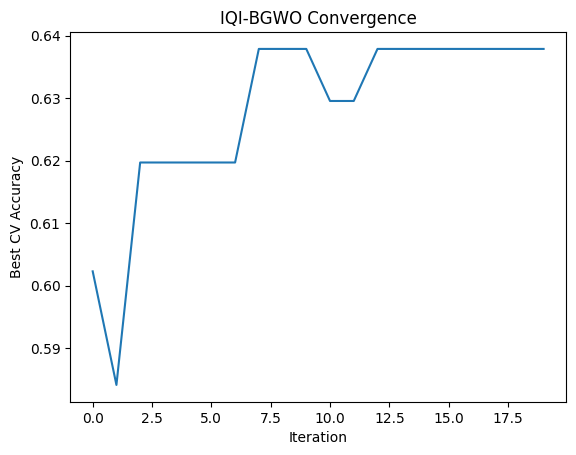

In [ ]:
#@title 10) Plot convergence curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(best_hist)
plt.xlabel("Iteration")
plt.ylabel("Best CV Accuracy")
plt.title("IQI‑BGWO Convergence")
plt.show()


In [ ]:
#@title 11) Baseline vs Optimized summary
summary = pd.DataFrame([
    {"model":"Baseline SVM (all features)", **baseline},
    {"model":"IQI‑BGWO‑SVM (selected features)", **final_metrics},
])
summary


,model,acc,sens,spec,mcc,auc
0,Baseline SVM (all features),0.549242,0.04,0.926190,-0.045771,0.478333
1,IQI‑BGWO‑SVM (selected features),0.637879,0.16,0.985714,0.201839,0.530714


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['acc'].plot(kind='hist', bins=20, title='acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['sens'].plot(kind='hist', bins=20, title='sens')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['spec'].plot(kind='hist', bins=20, title='spec')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='acc', y='sens', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='sens', y='spec', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='spec', y='mcc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['acc']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'acc'}, axis=1)
              .sort_values('acc', ascending=True))
  xs = counted['acc']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('acc', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('acc')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['sens']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'sens'}, axis=1)
              .sort_values('sens', ascending=True))
  xs = counted['sens']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('sens', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('sens')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['spec']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'spec'}, axis=1)
              .sort_values('spec', ascending=True))
  xs = counted['spec']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('spec', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('spec')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['acc'].plot(kind='line', figsize=(8, 4), title='acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['sens'].plot(kind='line', figsize=(8, 4), title='sens')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['spec'].plot(kind='line', figsize=(8, 4), title='spec')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='acc', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='sens', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='spec', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)